<a href="https://colab.research.google.com/github/DungNguyenCoding/FederatedLearning/blob/main/Projects/federated_learning_with_differential_privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Federated Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/federated/tutorials/federated_learning_with_differential_privacy"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/v0.88.0/docs/tutorials/federated_learning_with_differential_privacy.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/federated/blob/v0.88.0/docs/tutorials/federated_learning_with_differential_privacy.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/federated/docs/tutorials/federated_learning_with_differential_privacy.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Differential Privacy in TFF

This notebook will demonstrate the recommended best practice for training models with user-level Differential Privacy using Tensorflow Federated. We will use the DP-SGD algorithm of [Abadi et al., "Deep Learning with Differential Privacy"](https://arxiv.org/abs/1607.00133) modified for user-level DP in a federated context in [McMahan et al., "Learning Differentially Private Recurrent Language Models"](https://arxiv.org/abs/1710.06963).

Differential Privacy (DP) is a widely used method for bounding and quantifying the privacy leakage of sensitive data when performing learning tasks. Training a model with user-level DP guarantees that the model is unlikely to learn anything significant about the data of any individual, but can still (hopefully!) learn patterns that exist in the data of many clients.

We will train a model on the federated EMNIST dataset. There is an inherent trade-off between utility and privacy, and it may be difficult to train a model with high privacy that performs as well as a state-of-the-art non-private model. For expediency in this tutorial, we will train for just 50 rounds, sacrificing some quality in order to demonstrate how to train with high privacy. If we used more training rounds, we could certainly have a somewhat higher-accuracy private model, but not as high as a model trained without DP.

## Before we begin

First, let us make sure the notebook is connected to a backend that has the relevant components compiled.

In [ ]:
# 1. Uninstall conflicting packages (if needed)
!pip uninstall -y tensorflow tensorflow-federated tensorflow-privacy dp-accounting

# 2. Install specific versions known to work together
!pip install tensorflow==2.14.0
!pip install dp-accounting==0.4.3
!pip install tensorflow-privacy==0.9.0
!pip install tensorflow-federated==0.87.0

Some imports we will need for the tutorial. We will use `tensorflow_federated`, the open-source framework for machine learning and other computations on decentralized data, as well as `dp_accounting`, an open-source library for analyzing differentially private algorithms.

In [ ]:
import collections

import dp_accounting
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

Run the following "Hello World"
example to make sure the TFF environment is correctly setup. If it doesn't work,
please refer to the [Installation](../install.md) guide for instructions.

In [5]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

b'Hello, World!'

## Download and preprocess the federated EMNIST dataset.

In [6]:
def get_emnist_dataset():
  emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(
      only_digits=True)

  def element_fn(element):
    return collections.OrderedDict(
        x=tf.expand_dims(element['pixels'], -1), y=element['label'])

  def preprocess_train_dataset(dataset):
    # Use buffer_size same as the maximum client dataset size,
    # 418 for Federated EMNIST
    return (dataset.map(element_fn)
                   .shuffle(buffer_size=418)
                   .repeat(1)
                   .batch(32, drop_remainder=False))

  def preprocess_test_dataset(dataset):
    return dataset.map(element_fn).batch(128, drop_remainder=False)

  emnist_train = emnist_train.preprocess(preprocess_train_dataset)
  emnist_test = preprocess_test_dataset(
      emnist_test.create_tf_dataset_from_all_clients())
  return emnist_train, emnist_test

train_data, test_data = get_emnist_dataset()

## Define our model.

In [7]:
def my_model_fn():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(10)])
  return tff.learning.models.from_keras_model(
      keras_model=model,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      input_spec=test_data.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

## Determine the noise sensitivity of the model.

To get user-level DP guarantees, we must change the basic Federated Averaging algorithm in two ways. First, the clients' model updates must be clipped before transmission to the server, bounding the maximum influence of any one client. Second, the server must add enough noise to the sum of user updates before averaging to obscure the worst-case client influence.

For clipping, we use the adaptive clipping method of [Andrew et al. 2021, Differentially Private Learning with Adaptive Clipping](https://arxiv.org/abs/1905.03871), so no clipping norm needs to be explicitly set.

Adding noise will in general degrade the utility of the model, but we can control the amount of noise in the average update at each round with two knobs: the standard deviation of the Gaussian noise added to the sum, and the number of clients in the average. Our strategy will be to first determine how much noise the model can tolerate with a relatively small number of clients per round with acceptable loss to model utility. Then to train the final model, we can increase the amount of noise in the sum, while proportionally scaling up the number of clients per round (assuming the dataset is large enough to support that many clients per round). This is unlikely to significantly affect model quality, since the only effect is to decrease variance due to client sampling (indeed we will verify that it does not in our case).

To that end, we first train a series of models with 50 clients per round, with increasing amounts of noise. Specifically, we increase the "noise_multiplier" which is the ratio of the noise standard deviation to the clipping norm. Since we are using adaptive clipping, this means that the actual magnitude of the noise changes from round to round.

In [8]:
def evaluate(model_weights):
    keras_model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
        tf.keras.layers.Dense(200, activation=tf.nn.relu),
        tf.keras.layers.Dense(200, activation=tf.nn.relu),
        tf.keras.layers.Dense(10)
    ])
    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    model_weights.assign_weights_to(keras_model)

    # Convert test_data from OrderedDict to tuple (x, y)
    test_data_tuple = test_data.map(lambda batch: (batch['x'], batch['y']))

    return keras_model.evaluate(test_data_tuple, return_dict=True)

total_clients = len(train_data.client_ids)

def train(rounds, noise_multiplier, clients_per_round, data_frame):
    aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
        noise_multiplier, clients_per_round
    )

    sampling_prob = clients_per_round / total_clients

    learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
        model_fn=my_model_fn,
        client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.01),
        server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0, momentum=0.9),
        model_aggregator=aggregation_factory,
    )

    state = learning_process.initialize()

    for round in range(rounds):
        if round % 5 == 0:
            model_weights = learning_process.get_model_weights(state)
            metrics = evaluate(model_weights)
            if round < 25 or round % 25 == 0:
                print(f'Round {round:3d}: {metrics}')
            new_row = pd.DataFrame([{'Round': round,
                         'NoiseMultiplier': noise_multiplier,
                         **metrics}])
            data_frame = pd.concat([data_frame, new_row], ignore_index=True)


        # Poisson sampling of clients
        x = np.random.uniform(size=total_clients)
        sampled_clients = [
            train_data.client_ids[i] for i in range(total_clients)
            if x[i] < sampling_prob
        ]
        sampled_train_data = [
            train_data.create_tf_dataset_for_client(client)
            for client in sampled_clients
        ]

        result = learning_process.next(state, sampled_train_data)
        state = result.state

    # Final evaluation
    model_weights = learning_process.get_model_weights(state)
    metrics = evaluate(model_weights)
    print(f'Round {rounds:3d}: {metrics}')
    new_row = pd.DataFrame([{'Round': round,
                         'NoiseMultiplier': noise_multiplier,
                         **metrics}])
    data_frame = pd.concat([data_frame, new_row], ignore_index=True)


    return data_frame


In [12]:
data_frame = pd.DataFrame()
rounds = 50
clients_per_round = 50

In [13]:
noise_multiplier = 0.0
print(f'Starting training with noise multiplier: {noise_multiplier}')
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
print()

Starting training with noise multiplier: 0.0
319/319 [==============================] - 14s 43ms/step - loss: 2.6442 - sparse_categorical_accuracy: 0.1511
Round   0: {'loss': 2.6441564559936523, 'sparse_categorical_accuracy': 0.15108248591423035}
319/319 [==============================] - 5s 14ms/step - loss: 2.2217 - sparse_categorical_accuracy: 0.1749
Round   5: {'loss': 2.2217047214508057, 'sparse_categorical_accuracy': 0.17488734424114227}
319/319 [==============================] - 7s 21ms/step - loss: 2.1432 - sparse_categorical_accuracy: 0.2393
Round  10: {'loss': 2.1432125568389893, 'sparse_categorical_accuracy': 0.23929761350154877}
319/319 [==============================] - 5s 14ms/step - loss: 1.9613 - sparse_categorical_accuracy: 0.5391
Round  15: {'loss': 1.9612787961959839, 'sparse_categorical_accuracy': 0.5391359925270081}
319/319 [==============================] - 7s 20ms/step - loss: 1.7898 - sparse_categorical_accuracy: 0.4627
Round  20: {'loss': 1.7898343801498413, 's

In [14]:
noise_multiplier = 0.5
print(f'Starting training with noise multiplier: {noise_multiplier}')
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
print()

Starting training with noise multiplier: 0.5
319/319 [==============================] - 7s 21ms/step - loss: 2.5154 - sparse_categorical_accuracy: 0.1071
Round   0: {'loss': 2.515380859375, 'sparse_categorical_accuracy': 0.10712186247110367}
319/319 [==============================] - 5s 15ms/step - loss: 2.2321 - sparse_categorical_accuracy: 0.1229
Round   5: {'loss': 2.2320756912231445, 'sparse_categorical_accuracy': 0.12294279038906097}
319/319 [==============================] - 6s 17ms/step - loss: 2.1007 - sparse_categorical_accuracy: 0.2933
Round  10: {'loss': 2.1007018089294434, 'sparse_categorical_accuracy': 0.2933483421802521}
319/319 [==============================] - 6s 18ms/step - loss: 1.9026 - sparse_categorical_accuracy: 0.4924
Round  15: {'loss': 1.9026284217834473, 'sparse_categorical_accuracy': 0.4923834204673767}
319/319 [==============================] - 5s 14ms/step - loss: 1.6715 - sparse_categorical_accuracy: 0.6449
Round  20: {'loss': 1.6715233325958252, 'sparse_

In [15]:
noise_multiplier = 0.75
print(f'Starting training with noise multiplier: {noise_multiplier}')
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
print()

Starting training with noise multiplier: 0.75
319/319 [==============================] - 9s 26ms/step - loss: 2.6650 - sparse_categorical_accuracy: 0.1391
Round   0: {'loss': 2.664987802505493, 'sparse_categorical_accuracy': 0.13910658657550812}
319/319 [==============================] - 5s 15ms/step - loss: 2.2468 - sparse_categorical_accuracy: 0.1800
Round   5: {'loss': 2.2468371391296387, 'sparse_categorical_accuracy': 0.17995689809322357}
319/319 [==============================] - 5s 15ms/step - loss: 2.1250 - sparse_categorical_accuracy: 0.4355
Round  10: {'loss': 2.124955177307129, 'sparse_categorical_accuracy': 0.43551626801490784}
319/319 [==============================] - 6s 19ms/step - loss: 2.0072 - sparse_categorical_accuracy: 0.2226
Round  15: {'loss': 2.0072007179260254, 'sparse_categorical_accuracy': 0.22264400124549866}
319/319 [==============================] - 6s 17ms/step - loss: 1.7282 - sparse_categorical_accuracy: 0.5842
Round  20: {'loss': 1.7281534671783447, 'sp

In [19]:
noise_multiplier = 1.0
print(f'Starting training with noise multiplier: {noise_multiplier}')
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
print()

Starting training with noise multiplier: 1.0
319/319 [==============================] - 14s 43ms/step - loss: 2.6523 - sparse_categorical_accuracy: 0.0939
Round   0: {'loss': 2.652313232421875, 'sparse_categorical_accuracy': 0.09387245029211044}
319/319 [==============================] - 5s 14ms/step - loss: 2.2577 - sparse_categorical_accuracy: 0.1661
Round   5: {'loss': 2.2576584815979004, 'sparse_categorical_accuracy': 0.16607072949409485}
319/319 [==============================] - 7s 21ms/step - loss: 2.1330 - sparse_categorical_accuracy: 0.3424
Round  10: {'loss': 2.1330413818359375, 'sparse_categorical_accuracy': 0.342427521944046}
319/319 [==============================] - 5s 14ms/step - loss: 1.9405 - sparse_categorical_accuracy: 0.4426
Round  15: {'loss': 1.940459966659546, 'sparse_categorical_accuracy': 0.4425695538520813}
319/319 [==============================] - 5s 14ms/step - loss: 1.7038 - sparse_categorical_accuracy: 0.4590
Round  20: {'loss': 1.7037856578826904, 'spars

Now we can visualize the evaluation set accuracy and loss of those runs.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(data_frame):
  plt.figure(figsize=(15, 5))

  dff = data_frame.rename(
      columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')

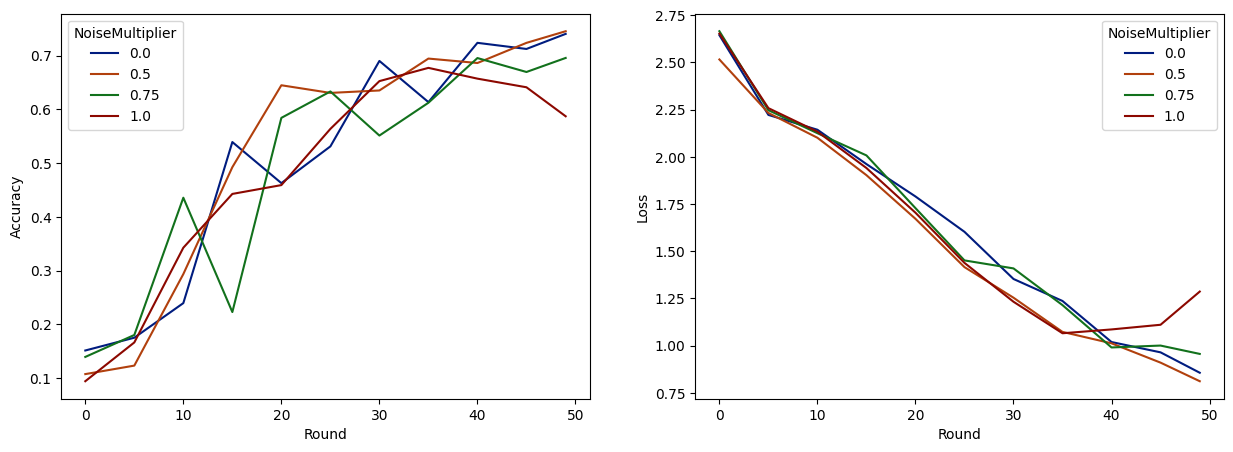

In [21]:
make_plot(data_frame)

It appears that with 50 expected clients per round, this model can tolerate a noise multiplier of up to 0.5 without degrading model quality. A noise multiplier of 0.75 seems to cause a bit of model degradation, and 1.0 makes the model diverge.

There is typically a tradeoff between model quality and privacy. The higher noise we use, the more privacy we can get for the same amount of training time and number of clients. Conversely, with less noise, we may have a more accurate model, but we'll have to train with more clients per round to reach our target privacy level.

With the experiment above, we might decide that the small amount of model deterioration at 0.75 is acceptable in order to train the final model faster, but let's assume we want to match the performance of the 0.5 noise-multiplier model.

Now we can use dp_accounting functions to determine how many expected clients per round we would need to get acceptable privacy. Standard practice is to choose delta somewhat smaller than one over the number of records in the dataset. This dataset has 3383 total training users, so let's aim for (2, 1e-5)-DP.

We use `dp_accounting.calibrate_dp_mechanism` to search over the number of clients per round. The privacy accountant (`RdpAccountant`) we use to estimate privacy given a `dp_accounting.DpEvent` is based on [Wang et al. (2018)](https://arxiv.org/abs/1808.00087) and [Mironov et al. (2019)](https://arxiv.org/pdf/1908.10530.pdf).

In [22]:
total_clients = 3383
noise_to_clients_ratio = 0.01
target_delta = 1e-5
target_eps = 2

# Initialize arguments to dp_accounting.calibrate_dp_mechanism.

# No-arg callable that returns a fresh accountant.
make_fresh_accountant = dp_accounting.rdp.RdpAccountant

# Create function that takes expected clients per round and returns a
# dp_accounting.DpEvent representing the full training process.
def make_event_from_param(clients_per_round):
  q = clients_per_round / total_clients
  noise_multiplier = clients_per_round * noise_to_clients_ratio
  gaussian_event = dp_accounting.GaussianDpEvent(noise_multiplier)
  sampled_event = dp_accounting.PoissonSampledDpEvent(q, gaussian_event)
  composed_event = dp_accounting.SelfComposedDpEvent(sampled_event, rounds)
  return composed_event

# Create object representing the search range [1, 3383].
bracket_interval = dp_accounting.ExplicitBracketInterval(1, total_clients)

# Perform search for smallest clients_per_round achieving the target privacy.
clients_per_round = dp_accounting.calibrate_dp_mechanism(
    make_fresh_accountant, make_event_from_param, target_eps, target_delta,
    bracket_interval, discrete=True
)

noise_multiplier = clients_per_round * noise_to_clients_ratio
print(f'To get ({target_eps}, {target_delta})-DP, use {clients_per_round} '
      f'clients with noise multiplier {noise_multiplier}.')

To get (2, 1e-05)-DP, use 103 clients with noise multiplier 1.03.


Now we can train our final private model for release.


319/319 [==============================] - 15s 46ms/step - loss: 2.6298 - sparse_categorical_accuracy: 0.0901
Round   0: {'loss': 2.6297550201416016, 'sparse_categorical_accuracy': 0.0901498794555664}
319/319 [==============================] - 11s 33ms/step - loss: 2.2670 - sparse_categorical_accuracy: 0.1111
Round   5: {'loss': 2.2670397758483887, 'sparse_categorical_accuracy': 0.11113832145929337}
319/319 [==============================] - 6s 19ms/step - loss: 2.1445 - sparse_categorical_accuracy: 0.3242
Round  10: {'loss': 2.144512891769409, 'sparse_categorical_accuracy': 0.32423099875450134}
319/319 [==============================] - 7s 22ms/step - loss: 1.9958 - sparse_categorical_accuracy: 0.4291
Round  15: {'loss': 1.995774745941162, 'sparse_categorical_accuracy': 0.4290997385978699}
319/319 [==============================] - 6s 19ms/step - loss: 1.7997 - sparse_categorical_accuracy: 0.5110
Round  20: {'loss': 1.7996801137924194, 'sparse_categorical_accuracy': 0.5109962821006775

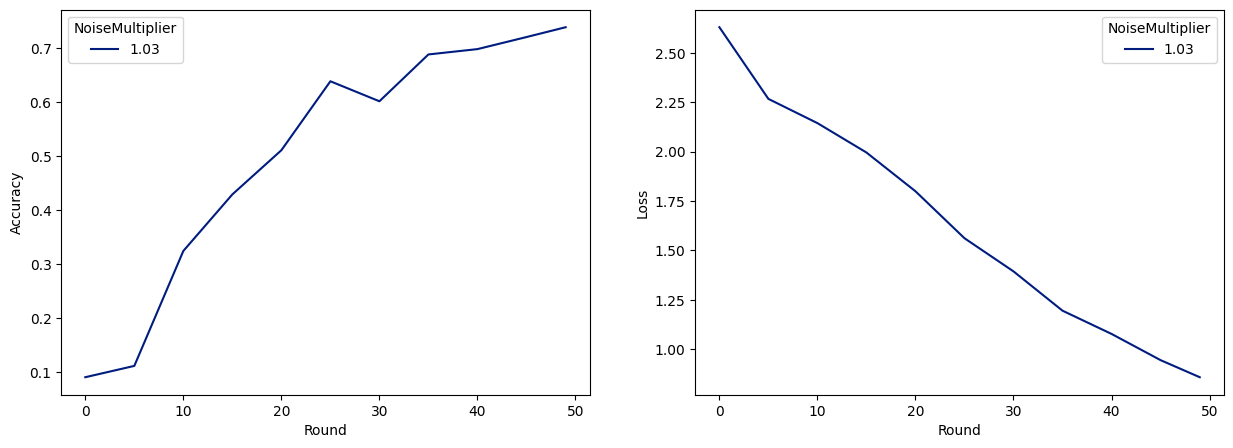

In [24]:
rounds = 50
noise_multiplier = 1.03
clients_per_round = 120

data_frame = pd.DataFrame()
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)

make_plot(data_frame)

As we can see, the final model has similar loss and accuracy to the model trained without noise, but this one satisfies (2, 1e-5)-DP.